# Exploring TC PRIMED, Chapter 2: Composite Analysis
- Creators: Naufal Razin, Kathy Haynes, and Chris Slocum
- Affiliations: CIRA and NESDIS/STAR

---

## Overview
With an extensive array of tropical cyclone passive microwave observations, retrieved precipitation, track and intensity information, and environmental diagnostics, TC PRIMED provides users with the opportunity to conduct a comprehensive study on tropical cyclone convective and precipitation structure, intensity, and environment. In this notebook, you will learn how to conduct a simple timeseries composite using TC PRIMED data.

## Prerequisites
To successfully navigate and use this notebook, you should be familiar with:
- the basics of Python programming such as loading modules, assigning variables, and list/array indexing
- NetCDF files and NetCDF groups (Chapter 1a of this Learning Journey)
- plotting data using matplotlib
- TC PRIMED overpass file data structure (Chapter 1b of this Learning Journey)
- TC PRIMED environmental file data structure (Chapter 1c of this Learning Journey)

## Learning Outcomes
By working through this notebook, you will learn how to:
- conduct a simple timeseries composite analysis using TC PRIMED data

## Background
One of the key concepts that is widely understood in the tropical cyclone community is the importance of robust convection in the tropical cyclone inner-core for achieving and maintaining strong tropical cyclone winds. Strong inner-core convection often coincide with more intense tropical cyclones that have a maximum 1-minute average tangential wind speed in the middle-to-higher end of the [Saffir-Simpson Hurricane Wind Scale](https://www.nhc.noaa.gov/aboutsshws.php#:~:text=The%20Saffir%2DSimpson%20Hurricane%20Wind,Scale%20estimates%20potential%20property%20damage.). Forecasters often analyze satellite passive microwave observations to gain insight into the convective structure of tropical cyclones and predict its intensity trend. In this notebook, you will learn to use passive microwave observations from TC PRIMED to conduct a simple timeseries composite, and relate the tropical cyclone convective structure to intensity.

### Hurricane Florence (2018)
In this example, we will use TC PRIMED files from Hurricane Florence (2018). If you have gone through the earlier notebooks in this series, you should be familiar with Hurricane Florence. Hurricane Florence was a long-lived hurricane that formed off the coast of Senegal and The Gambia, and tracked westward across the North Atlantic Ocean. During its track across the Atlantic, it briefly intensified to a Category 4 hurricane, weakened to a tropical storm, and re-intensified back to a Category 4 hurricane before making landfall along the southeastern coast of North Carolina as a high-end Category 1 hurricane. Florence brought [record-breaking rainfall](https://www.weather.gov/ilm/HurricaneFlorence) across eastern North Carolina and parts of northeastern South Carolina.

<figure>
<img alt="An image of Hurricane Florence (2018) captured by European Space Agency astronaut Alexander Gerst from aboard the International Space Station." src="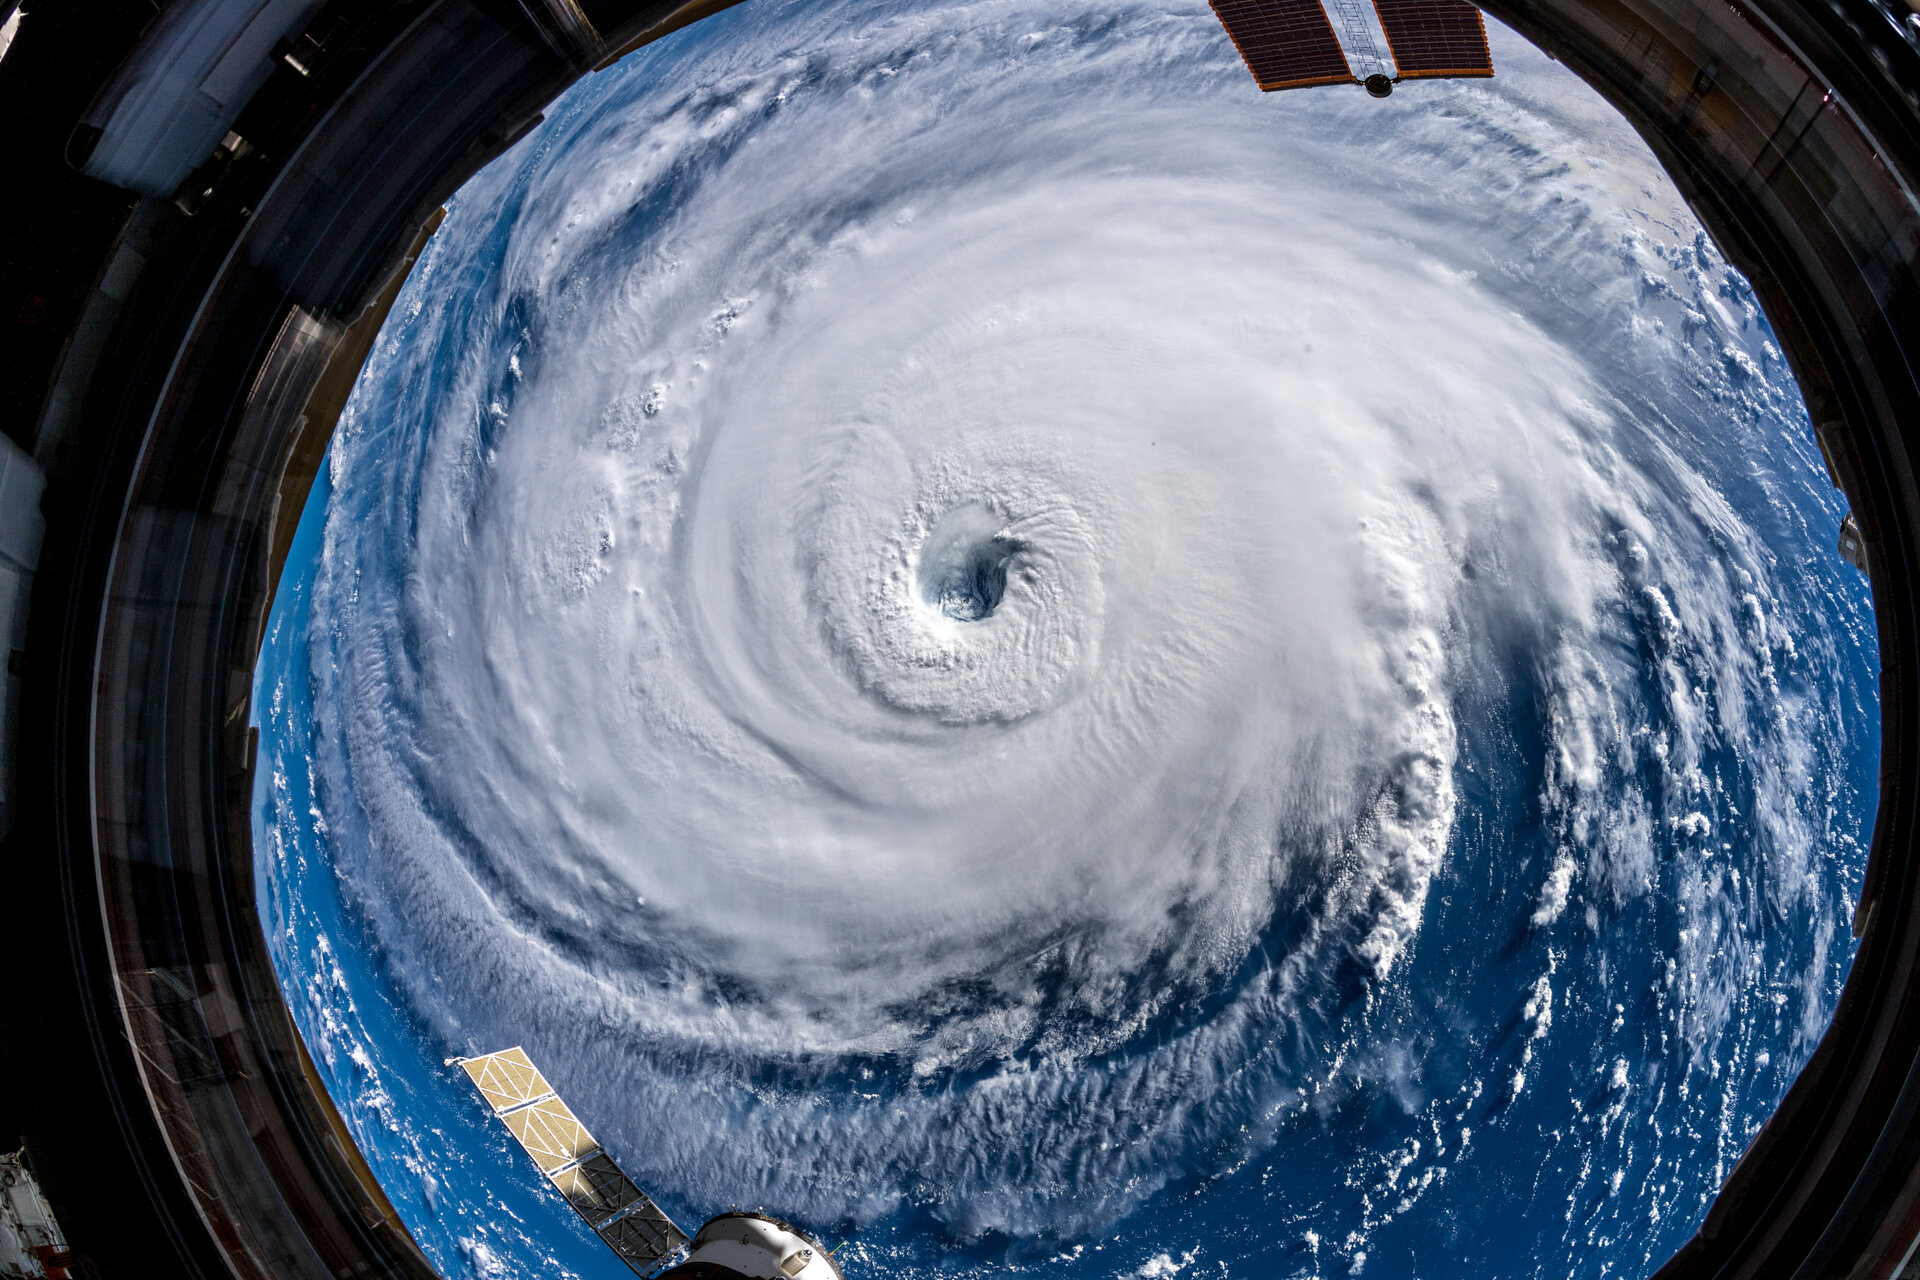" width="900">

<figcaption align = "center"><b>Figure 1.</b> An image of Hurricane Florence (2018) captured by European Space Agency astronaut Alexander Gerst from aboard the International Space Station. Source: <a href="https://www.esa.int/ESA_Multimedia/Images/2018/09/Above_Hurricane_Florence">ESA</a></figcaption>
</figure>

### Passive Microwave Observations in the 85 to 92 GHz Frequency Window
In this notebook, we will relate the convective structure of Hurricane Florence to its intensity. More precisely, we will look at passive microwave signatures in the 85 to 92 GHz frequency window to infer the strength and location of convection. In this frequency window, large precipitation-sized ice particles, such as that found in deep convection, scatter radiation from the Earth. The scattering of Earth radiation results in observations of localized low brightness temperatures. Stronger convection produces larger ice particles, which result in stronger scattering of Earth radiation and therefore, lower brightness temperatures.

Other sources can also influence passive microwave brightness temperatures to produce low or high brightness temperatures, like land. To remove the effect of varying brightness temperatures to the varying properties of the Earth's surface and isolate just the ice-scattering signatures, satellite analysts use the polarization-corrected brightness temperature (PCT), which uses a combination of the observations from the vertically- and horizontally- polarized brightness temperatures. In this notebook, we will use the equation for PCT from Cecil and Chronis (2018), where

$$
  PCT = {TB}_{V} \times 1.7 - {TB}_{H} \times 0.7
$$

Here, ${TB}_{V}$ is the vertically-polarized brightness temperature and ${TB}_{H}$ is the horizontally-polarized brightness temperature.

## Software
This tutorial uses the Python programming language and packages. We will use:
- `netCDF4` to read in the TC PRIMED file
- `matplotlib` to plot the data
- `numpy` for simple array operations
- `scipy` for calculating bin statistics

### Install Packages
Let's first check if we have the necessary Python packages to run this notebook. If we don't, let's install them.

In [ ]:
import subprocess, sys
packages = ["netCDF4", "matplotlib", "numpy", "scipy"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

Now, let's load the modules in the packages (e.g., `Dataset`) or load the packages and assign a shorter object name for the packages (e.g., `import matplotlib.pyplot as plt`) for a cleaner use throughout the notebook.

In [ ]:
# Load the Python packages we will use in this notebook
import datetime
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## File Selection
When choosing the files to conduct the analysis, there are several key aspects of passive microwave observations that users should note:
- Cross-track-scanning passive microwave sensors have varying instantaneous fields-of-view (IFOV) across its swath, with the smallest IFOV (highest resolution) at nadir and the biggest IFOV (coarsest resolution) at the edge of its swath. Whereas conical-scanning passive microwave sensors have a constant IFOV/resolution across its swath.
- Different passive microwave sensors have different instantaneous fields-of-view (IFOV). Some sensors have smaller IFOV (higher resolution) while other sensors have bigger IFOV (coarser resolution). For more information, see Figure 1 from Chapter 1b of this Learning Journey.
- Some sensors are available on only one satellite (e.g., the Global Precipitation Measurement (GPM) Microwave Imager (GMI)), while other sensors are available on multiple satellites (e.g., the Special Sensor Microwave/Imager (SSM/I))
- Different observing frequencies do not produce the same brightness temperature observation. In other words, given all else equal, the observation of a convective cell at the 85.5 GHz frequency would not yield the same brightness temperature value as the same observation in at the 89.0 GHz frequency.

When doing a timeseries composite, particularly from only one storm, we want to select a sensor that is available on multiple satellites to increase our chances of obtaining multiple observations of the storm throughout its life. In addition, we want to ensure consistent observations such that the sensor characteristics do not influence the observed brightness temperatures. Therefore, we will use observations from only the conical-scanning SSMIS sensor in this notebook. Within the range of the 85 to 92 GHz observation frequency, the Special Sensor Microwave - Imager/Sounder (SSMIS) sensor has an observation frequency at 91.665 GHz (92 GHz, for brevity).

## Read Files Online
Let's retrieve the files that we will use in this example. As we have mentioned above, the TC PRIMED files will be from SSMIS overpasses of Hurricane Florence (2018). We will use the Python `netCDF4` and `requests` packages to read and retrieve the information directly from the TC PRIMED files available on an Amazon Web Service S3 bucket as part of the NOAA Open Data Dissemination program (NODD), without downloading the file, and store the information from the file in an "instance" type called `DS`.

**Note that here, we have pre-selected the overpasses with a good observational coverage of the storm and organized them in the order of increasing time. And, with the number of files we will be reading, this code block will take some time to run.**

In [ ]:
import requests

# Specify the URL to the TC PRIMED folder on NODD
NODD_URL = "https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/v01r00/final/2018/AL/06/"

# Specify the name of the files we will use from the TC PRIMED folder on NODD
OVERPASS_FILE_NAMES = [
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076709_20180830164830.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045726_20180830185530.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_060995_20180830195230.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076716_20180831052431.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061009_20180831193931.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045747_20180901072001.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061016_20180901081501.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076738_20180901180401.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076752_20180902175102.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045769_20180902200102.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061038_20180902205402.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076759_20180903062503.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045776_20180903083503.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061045_20180903092803.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045783_20180903194903.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061052_20180903204203.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045790_20180904082304.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061059_20180904091504.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076795_20180905185505.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045812_20180905210705.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076802_20180906072606.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045819_20180906093806.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061088_20180906102906.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076809_20180906184306.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045826_20180906205406.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061095_20180906214506.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076816_20180907071307.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045833_20180907092507.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061102_20180907101507.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045840_20180907204207.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061109_20180907213207.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045847_20180908091308.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061116_20180908100208.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076852_20180909194509.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076859_20180910081510.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045876_20180910102910.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061145_20180910111710.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076866_20180910193210.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061152_20180910223310.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076873_20180911080211.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045890_20180911101611.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061159_20180911110311.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045897_20180911213511.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061166_20180911222111.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076895_20180912204912.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076902_20180913091513.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045919_20180913113113.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061188_20180913121513.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076909_20180913203713.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045926_20180913225313.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061195_20180913233713.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076916_20180914090214.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045933_20180914111814.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061202_20180914120214.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F16_076923_20180914202414.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045940_20180914224014.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061209_20180914232414.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045947_20180915110615.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061216_20180915114915.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F18_045954_20180915222815.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061223_20180915231115.nc",
    "TCPRIMED_v01r00-final_AL062018_SSMIS_F17_061245_20180917130217.nc"
]

# Declare DS as a dictionary
DS = {}

# Loop through each overpass file name
for overpass_file_name in OVERPASS_FILE_NAMES:

    # Join NODD_URL and overpass_file_name to produce a complete link
    # Retrieve the contents of the TC PRIMED file from the complete link
    url_response = requests.get(NODD_URL + overpass_file_name)

    # Load the contents of the TC PRIMED file in an "instance" type into the
    # dictionary DS with the file name as the dictionary key
    DS[overpass_file_name] = Dataset(overpass_file_name, memory=url_response.content)

Since we want to relate the passive microwave convective signatures with the tropical cyclone intensity, let's retrieve and read information from the TC PRIMED environmental file.

In [ ]:
# Specify the name of the file we will use from the TC PRIMED folder on NODD
ENV_FILE_NAME = "TCPRIMED_v01r00-final_AL062018_era5_s20180830060000_e20180918120000.nc"

# Join NODD_URL and ENV_FILE_NAME to produce a complete link
# Retrieve the contents of the TC PRIMED file from the complete link
url_response = requests.get(NODD_URL + ENV_FILE_NAME)

# Load the contents of the TC PRIMED file in an "instance" type into the
# dictionary DS with the filename as the dictionary key
DS[ENV_FILE_NAME] = Dataset(ENV_FILE_NAME, memory=url_response.content)

First, let's load the intensity information from the TC PRIMED environmental file.

In [ ]:
# Load the time and intensity data from the storm_metadata
# group of the TC PRIMED environmental file
storm_metadata_time = DS[ENV_FILE_NAME]["/storm_metadata/time"][:]
storm_metadata_vmax = DS[ENV_FILE_NAME]["/storm_metadata/intensity"][:]

# All time variables in TC PRIMED files are stored in units
# of seconds since 1970-01-01, a.k.a., the Unix time stamp
# Convert this Unix time stamp array into a Python datetime
# array.
# Then, convert this Python datetime array into a string array
# in the form of "month/day hour"
storm_metadata_datetime = [datetime.datetime.fromtimestamp(t) for t in storm_metadata_time]
storm_metadata_datetime_str = [t.strftime("%m/%d %H") for t in storm_metadata_datetime]

## Selecting Parameters for Timeseries Composite
Since we want to present our data in the form of a timeseries, our output data array must have time as one of its dimensions. This time dimension corresponds to the time of the passive microwave observation throughout Hurricane Florence's life, which is the same as the number of TC PRIMED overpass files. We also want to show the evolution of the passive microwave convective signature &mdash; how strong it is and where it is located in Hurricane Florence. One way to do this is by taking the average passive microwave brightness temperature within various radial regions around the center of Hurricane Florence. Therefore, we will need to specify our radial bins for these radial regions. Let's do that first.

In [ ]:
# Radial bin parameters
radial_bins_min = 0     # Innermost radius used for binning, in km
radial_bins_max = 301   # Outermost radius used for binning, in km
radial_bins_size = 25   # Size of the radial bin, in km
# Generate array of the radial bins
radial_bins = np.arange(radial_bins_min,radial_bins_max,radial_bins_size)

# When storing and plotting the mean brightness temperatures, we will want to use
# the center of the radial bins, which has a size equivalent to len(radial_bins) - 1.
# Let's obtain that.
radial_bin_center = np.arange(radial_bins_min + (radial_bins_size/2),
                              radial_bins_max - (radial_bins_size/2) + 1,
                              radial_bins_size)

# Initialize time array, which has the same size as the number of
# selected observations of Hurricane Florence
overpass_times = np.zeros(len(OVERPASS_FILE_NAMES))

# Initialize array to store mean PCT values
stat_pct92 = np.zeros((overpass_times.size, radial_bin_center.size))

## Timeseries Composite
Compositing the timeseries consists of several steps. At each observation time:
- Load the necessary variables
- Using the x and y (or zonal and meridional) distance of the observation pixels for each overpass, calculate the radius of the observation pixels
- Using the horizontally and vertically polarized 92 GHz observation, calculate the polarization-corrected brightness temperatures (PCT)
- Bin the PCT into the radial bins and calculate the mean in each bin. This process is automatically handled by scipy's binned_statistic function.

In [ ]:
# Loop through each file from each selected observation time
# NOTE: we have already arranged the files in the order of increasing
# time

# Specify the statistic we want to calculate in each radial bin
# Options include mean, std, median, count, sum, min, max, or
# a user-defined or numerical function (e.g., np.nanmean)
stat = 'mean'
for file_idx, overpass_file_name in enumerate(OVERPASS_FILE_NAMES):

    # Load the overpass time variable
    overpass_time = DS[overpass_file_name]["/overpass_metadata/time"][:][0]
    # Put the overpass time variable into the array we specified above
    overpass_times[file_idx] = overpass_time

    # Load the x and y values for the pixels in the S4 swath
    # (corresponding to the swath for the 92 GHz observation)
    S4_x = DS[overpass_file_name]["/passive_microwave/S4/x"][:]
    S4_y = DS[overpass_file_name]["/passive_microwave/S4/y"][:]
    # Calculated the radius of the pixels in the S4 swath relative
    # to the storm center
    S4_r = np.sqrt(S4_x**2 + S4_y**2)

    # Load the horizontal and vertical polarization brightness temperature
    # at 92 GHz
    S4_v92 = DS[overpass_file_name]["/passive_microwave/S4/TB_91.665V"][:]
    S4_h92 = DS[overpass_file_name]["/passive_microwave/S4/TB_91.665H"][:]

    # Calculate the PCT using the horizontal and vertical polarization
    # brightness temperature
    S4_pct92 = S4_v92 * 1.7 - S4_h92 * 0.7

    # Using scipy's binned_statistic, bin the PCT into the radial bins we have
    # specified above and calculate the statistic
    # To ensure a single value is returned for each radial bin, we will have to
    # flatten the radius and PCT arrays
    stat_pct92[file_idx, :], \
    bin_edges, \
    bin_number = stats.binned_statistic(S4_r.flatten(), S4_pct92.flatten(),
                                        statistic=stat, bins=radial_bins)

## Plotting the Timeseries
Now you are ready to plot the timeseries composite! To show how the passive microwave convective signature evolves with Hurricane Florence's intensity, we will also plot the intensity evolution on the same figure using the `twiny()` function. Therefore, the radius bins will be located on the axis at the bottom of the figure, while the tropical cyclone intensity will be located on the axis at the top of the figure. The mean 92 GHz PCT and tropical cyclone intensity will share the same y-axis corresponding to time.

In [ ]:
# Set the figure size
plt.figure(figsize=(7, 10))

# Plot the mean 92 GHz PCT in each radial bin and at each selected
# observation time
# Specify the colormap and contour levels to use
plt.contourf(radial_bin_center, overpass_times, stat_pct92,
             cmap="inferno_r",
             levels=np.arange(220, 291, 2),
             extend="both")
# Plot and label the colorbar
plt.colorbar(label="91.665-GHz Brightness Temperature (K)")
# Label the x axis
plt.xlabel("Radial Bins (km)")

# Generate new x-axis sharing the y-axis with the plot above
plt.twiny()

# Plot the intensity values throughout the storm's life
plt.plot(storm_metadata_vmax, storm_metadata_time, color="k", lw=5)

# Label the x axis
plt.xlabel("Intensity (knots)")

# Recall that the time units are still in Unix time
# Replace the Unix time with the time string array we
# generated above and only plot the ticks at every
# fourth entry
plt.yticks(storm_metadata_time[::4], storm_metadata_datetime_str[::4]);

## Analysis
First, notice that at different points throughout Hurricane Florence's life, pockets of low mean 92 GHz PCT (lower than 230 Kelvin) exist in radial bins less than 50 to 100 km from the storm center. Recall that low brightness temperatures in this observation frequency correspond to strong convection that produces large precipitation-sized ice particles that scatter Earth radiation. Therefore, you can infer that at these times and these radial bins that are close to the inner core, strong convection exist.

If you compare these convective signals with the evolution of Hurricane Florence's intensity, you can see that they correspond to really strong intensities, above 80 knots!

Second, notice at the times corresponding to stronger intensities, lower mean 92 GHz PCT (lower than 250 Kelvin) also extend farther out, radially. In the context of our averaging approach, the larger extent of lower mean 92 GHz PCT may correspond to an increase in the number of strong, isolated convective cells or an increase in the number of moderate, widespread convective cells.

Nonetheless, the timeseries composite shows a strong relationship between the strength and location of convective signatures (hence, convection) and a tropical cyclone's intensity.

## Practice
1. Instead of calculating and plotting the mean in each bin, obtain and plot the number of pixel count (`count`) available in each radial bin. You will have to change the countour levels when making the plot. Why does the pixel count have that pattern? What does the pixel count pattern say about the area involved in the calculation of a statistic like the mean?
2. We have seen how the passive microwave convective signatures relate to the intensity of Hurricane Florence. Repeat the timeseries composite above to show how the GPROF retrieved surface precipitation rate changes as the environmental humidity around Hurricane Florence changes.

    **Hint:** Experiment with a relative humidity time series at the vertical level and averaging region of your choice.

## Close the File
When loading data from a NetCDF file, **always remember to close the file**. A best practice would be to close the file immediately after loading the variable or attribute of interest. However, since we're loading various variables and attributes throughout this notebook, we will close the files at the end of this notebook using the command below.

In [ ]:
DS[ENV_FILE_NAME].close()

for overpass_file_name in OVERPASS_FILE_NAMES:
    DS[overpass_file_name].close()

## Final Thoughts
In this tutorial, you learned how to generate a simple timeseries composite from observations of Hurricane Florence (2018) and saw how convection evolves with intensity and vice versa. This timeseries composite represents one of many ways you can use TC PRIMED data. You're not limited to generating a timeseries composite. You can create other types of composites, like a composite in the x and y dimensions, and using other criteria such as observations that meet only certain environmental characteristics.

## Data Statement
- Razin, Muhammad Naufal; Slocum, Christopher J.; Knaff, John A.; Brown, Paula J. 2023. Tropical Cyclone PRecipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED). v01r00. NOAA National Centers for Environmental Information. https://doi.org/10.25921/dmy1-0595.

## References
- Cecil, D. J., and T. Chronis, 2018: Polarization-corrected temperatures for 10-, 19-, 37-, and 89-GHz passive microwave frequencies. J. Appl. Meteor. Climatol., 57, 2249–2265, https://doi.org/10.1175/JAMC-D-18-0022.1.

## Metadata
- Language / package(s)
    - Python
    - NetCDF
    - Scipy
    - Matplotlib
- Domain
    - NOAA
    - NASA
    - JTWC
- Application keywords
    - Satellite passive microwave
    - Timeseries
- Geophysical keywords
    - Tropical cyclones
    - Convection